Simulating hop 1...
Simulating hop 2...
Simulating hop 3...
Simulating hop 4...
Simulating hop 5...
Simulating hop 6...
Simulating hop 7...
Simulating hop 8...
Simulating hop 9...
Simulating hop 10...
Simulating hop 11...
Simulating hop 12...
Simulating hop 13...
Simulating hop 14...
Simulating hop 15...
Simulating hop 16...
Simulating hop 17...
Simulating hop 18...
Simulating hop 19...
Simulating hop 20...
Simulating hop 21...
Simulating hop 22...
Simulating hop 23...
Simulating hop 24...
Simulating hop 25...
Simulating hop 26...
Simulating hop 27...
Simulating hop 28...
Simulating hop 29...
Simulating hop 30...
Simulating hop 31...
Simulating hop 32...
Simulating hop 33...
Simulating hop 34...
Simulating hop 35...
Simulating hop 36...
Simulating hop 37...
Simulating hop 38...
Simulating hop 39...
Simulating hop 40...
Simulating hop 41...
Simulating hop 42...
Simulating hop 43...
Simulating hop 44...
Simulating hop 45...
Simulating hop 46...
Simulating hop 47...
Simulating hop 48...
S

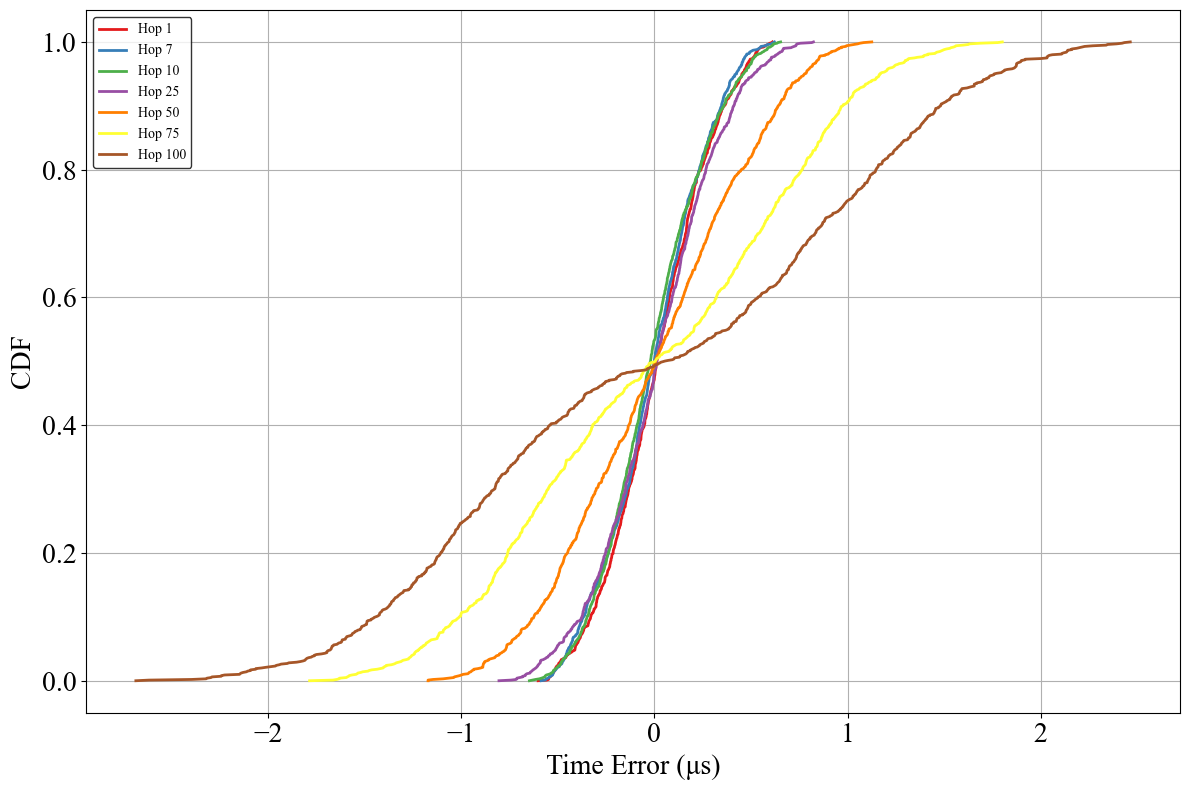

In [4]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/12 20:11
*  @Project :   pj_gptp_simulation
*  @Description :   从ieee8021as_simulation.py 拷贝来的版本
*  @FileName:   main.py
**************************************
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Create the output directory
os.makedirs("version/20250413/output_data", exist_ok=True)

# Parameters from the paper
PHY_JITTER_MAX = 8e-9  # 8 ns
CLOCK_GRANULARITY = 8e-9  # 8 ns
MAX_DRIFT_RATE = 10e-6  # 10 ppm
NR_ERROR = 0.1e-6  # 0.1 ppm
RESIDENCE_TIME_MAX = 1e-3  # 1 ms
PROPAGATION_DELAY = 62e-9  # 62 ns
SYNC_INTERVAL = 31.25e-3  # 31.25 ms
NUM_SAMPLES = 1000  # Samples per hop


def calculate_time_error(hops, sync_interval=SYNC_INTERVAL):
    """
    Calculate time synchronization error based on the paper's equations.
    """
    # Basic error from clock drift (equation 11)
    gm_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    node_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    basic_error = (node_drift - gm_drift) * sync_interval

    # Errors due to PHY jitter and clock granularity
    if hops > 1:
        # Timestamp error
        timestamp_error = np.random.uniform(0, PHY_JITTER_MAX) + np.random.uniform(0, CLOCK_GRANULARITY)

        # Error propagation factor based on equations (16)-(23)
        error_factor = np.random.uniform(0.5, 1.0)

        # Calculate accumulated error (grows with hop count)
        accumulated_error = timestamp_error * error_factor * hops

        # From Figure 10 - error grows faster after ~30 hops
        if hops > 30:
            accumulated_error *= 1 + (hops - 30) / 100
    else:
        accumulated_error = 0

    # Total error
    total_error = basic_error + accumulated_error

    # Randomize sign (error can be positive or negative)
    if np.random.random() < 0.5:
        total_error = -total_error

    return total_error


# Generate data for all hops (1-100)
all_data = {}
for h in range(1, 101):
    print(f"Simulating hop {h}...")
    hop_errors = [calculate_time_error(h) for _ in range(NUM_SAMPLES)]
    all_data[h] = hop_errors

# Save to CSV with each column representing one hop
df = pd.DataFrame({hop: all_data[hop] for hop in range(1, 101)})
df.to_csv("version/20250413/output_data/te_data.csv", index=False)

# Target hops for plotting
target_hops = [1, 7, 10, 25, 50, 75, 100]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'  # 棕色
}

# Create plot of time error distributions
plt.figure(figsize=(12, 8))

for i, hop in enumerate(target_hops):
    # Extract data for this hop and convert to microseconds
    errors = np.array(all_data[hop])
    errors_us = errors * 1e6

    # Sort errors for CDF plot
    sorted_errors = np.sort(errors_us)
    cumulative_prob = np.linspace(0, 1, len(sorted_errors))

    plt.plot(sorted_errors, cumulative_prob,
             label=f'Hop {hop}',
             color=colors[str(i + 1)],
             linewidth=2)

# Configure plot appearance
plt.grid(True)
plt.xlabel('Time Error (μs)', fontname='Times New Roman', fontsize=20, fontweight='bold')
plt.ylabel('CDF', fontname='Times New Roman', fontsize=20, fontweight='bold')

plt.legend(fontsize=20, frameon=True, shadow=False, edgecolor='black',prop={'family': 'Times New Roman'})

plt.xticks(fontname='Times New Roman', fontsize=20)
plt.yticks(fontname='Times New Roman', fontsize=20)

plt.tight_layout()
plt.savefig("version/20250413/output_image/time_error_cdf.png", dpi=600)
plt.show()


# 读取 csv并画图
version/20250413/output_data/te_data.csv

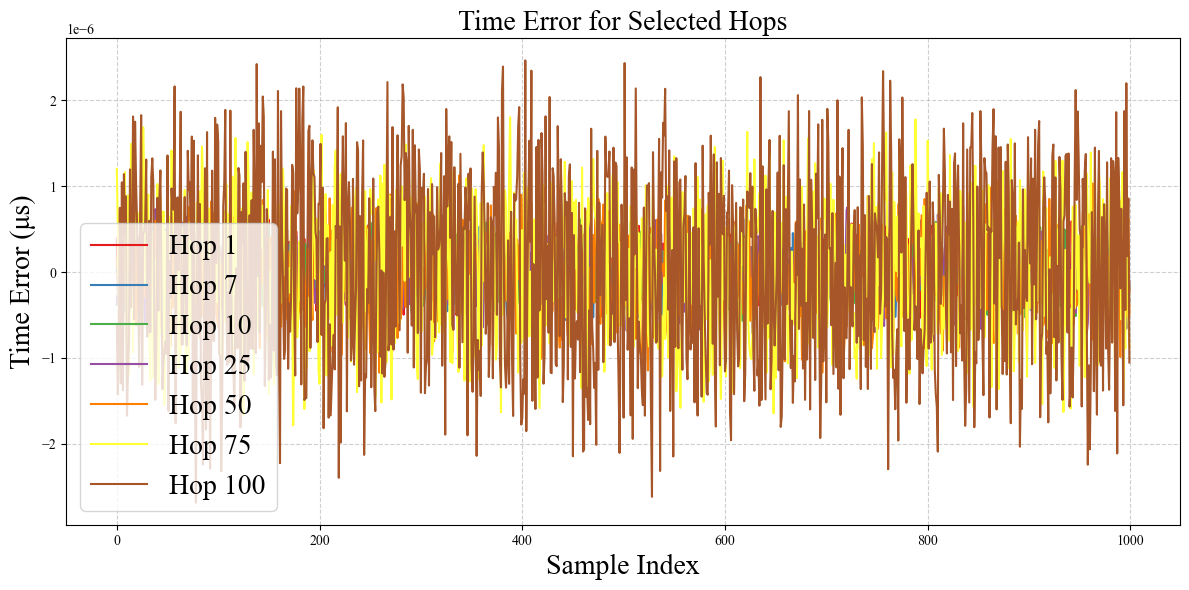

Image saved to: version/20250413/output_image\time_error_lines.png


<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 定义文件路径
input_file = 'version/20250413/output_data/te_data.csv'
output_dir = 'version/20250413/output_image'
output_file = os.path.join(output_dir, 'time_error_lines.png')

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 定义要提取的跳数和对应的颜色
selected_hops = [1, 7, 10, 25, 50, 75, 100]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'   # 棕色
}

# 读取CSV文件
data = pd.read_csv(input_file)

# 提取指定跳数的数据
selected_data = data.iloc[:, [hop-1 for hop in selected_hops]]  # 列索引从0开始

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制每条线
for i, hop in enumerate(selected_hops):
    color_key = str(i+1) if i+1 <= len(colors) else '1'  # 如果颜色不够用，默认使用第一种颜色
    plt.plot(selected_data.iloc[:, i], 
             label=f'Hop {hop}', 
             color=colors[color_key],
             linewidth=1.5)

# 添加图例和标签
plt.xlabel('Sample Index', fontsize=20)
plt.ylabel('Time Error (μs)', fontsize=20)
plt.title('Time Error for Selected Hops', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 保存图形
plt.savefig(output_file, dpi=600, bbox_inches='tight')
print(f'Image saved to: {output_file}')


# 将ns转化为微秒

In [9]:
import pandas as pd

# 读取CSV文件
input_path = r'D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data.csv'
output_path =r'D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\convert_te_data.csv'

# 读取数据
df = pd.read_csv(input_path)

# 添加行号列
df.insert(0, 'Row', range(1, len(df)+1))

# 将所有时间列从ns转换为μs，并保留3位小数
for col in df.columns:
    if col != 'Row':  # 跳过行号列
        df[col] = (df[col] / 1000).round(3)  # ns转μs并保留3位小数

# 保存结果
df.to_csv(output_path, index=False)

print(f"处理完成，结果已保存到 {output_path}")


处理完成，结果已保存到 D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\convert_te_data.csv


# 将结果图的线的上下顺序倒置，方便观察

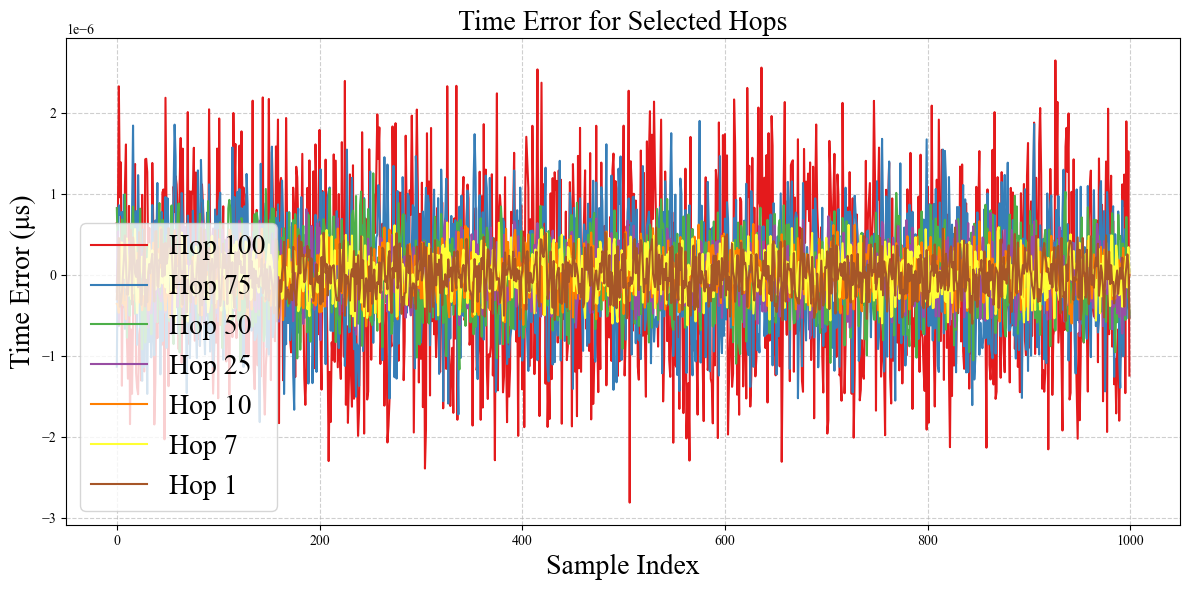

Image saved to: output_image\time_error_lines.png


<Figure size 640x480 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 定义文件路径
input_file = 'output_data/te_data.csv'
output_dir = 'output_image'
output_file = os.path.join(output_dir, 'time_error_lines.png')

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 定义要提取的跳数和对应的颜色
# selected_hops = [1, 7, 10, 25, 50, 75, 100]
selected_hops = [100, 75, 50, 25, 10, 7, 1]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'   # 棕色
}

# 读取CSV文件
data = pd.read_csv(input_file)

# 提取指定跳数的数据
selected_data = data.iloc[:, [hop-1 for hop in selected_hops]]  # 列索引从0开始

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制每条线
for i, hop in enumerate(selected_hops):
    color_key = str(i+1) if i+1 <= len(colors) else '1'  # 如果颜色不够用，默认使用第一种颜色
    plt.plot(selected_data.iloc[:, i], 
             label=f'Hop {hop}', 
             color=colors[color_key],
             linewidth=1.5)

# 添加图例和标签
plt.xlabel('Sample Index', fontsize=20)
plt.ylabel('Time Error (μs)', fontsize=20)
plt.title('Time Error for Selected Hops', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 保存图形
plt.savefig(output_file, dpi=600, bbox_inches='tight')
print(f'Image saved to: {output_file}')


# 尝试125ms

Simulating hop 1...
Simulating hop 2...
Simulating hop 3...
Simulating hop 4...
Simulating hop 5...
Simulating hop 6...
Simulating hop 7...
Simulating hop 8...
Simulating hop 9...
Simulating hop 10...
Simulating hop 11...
Simulating hop 12...
Simulating hop 13...
Simulating hop 14...
Simulating hop 15...
Simulating hop 16...
Simulating hop 17...
Simulating hop 18...
Simulating hop 19...
Simulating hop 20...
Simulating hop 21...
Simulating hop 22...
Simulating hop 23...
Simulating hop 24...
Simulating hop 25...
Simulating hop 26...
Simulating hop 27...
Simulating hop 28...
Simulating hop 29...
Simulating hop 30...
Simulating hop 31...
Simulating hop 32...
Simulating hop 33...
Simulating hop 34...
Simulating hop 35...
Simulating hop 36...
Simulating hop 37...
Simulating hop 38...
Simulating hop 39...
Simulating hop 40...
Simulating hop 41...
Simulating hop 42...
Simulating hop 43...
Simulating hop 44...
Simulating hop 45...
Simulating hop 46...
Simulating hop 47...
Simulating hop 48...
S

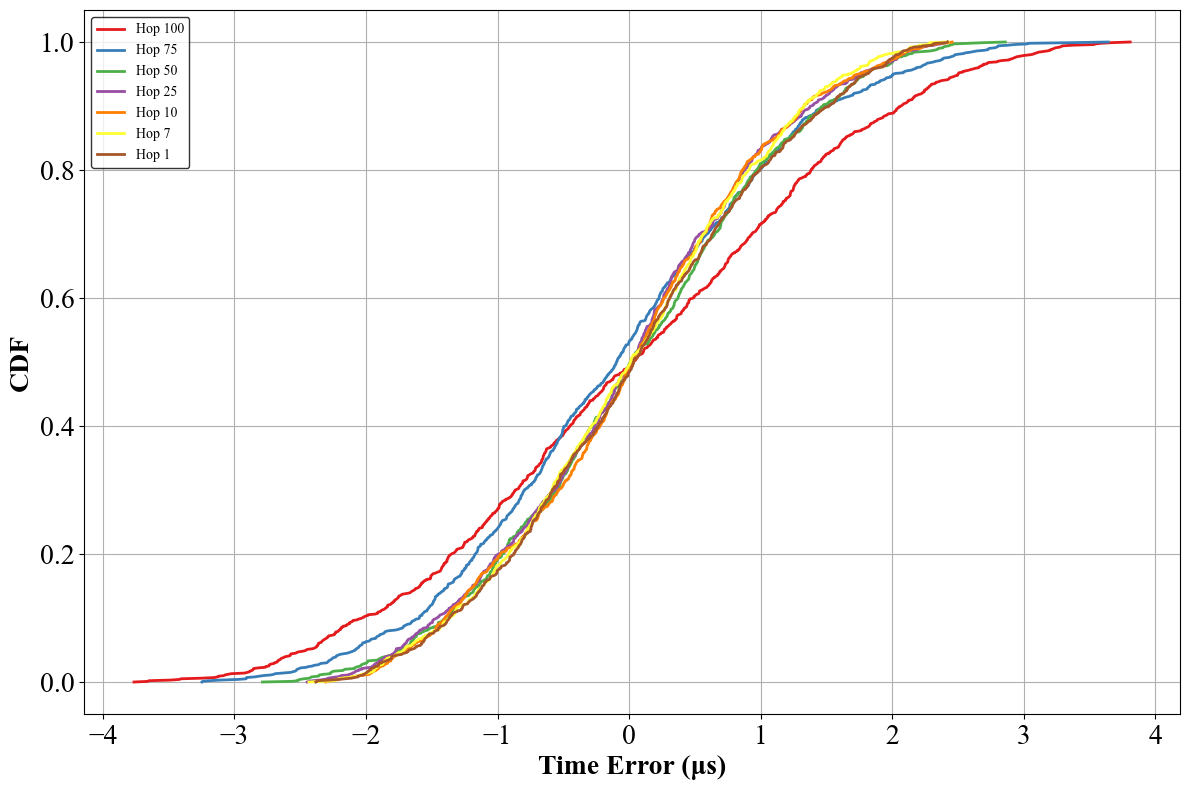

In [13]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/12 20:11
*  @Project :   pj_gptp_simulation
*  @Description :   从ieee8021as_simulation.py 拷贝来的版本
*  @FileName:   main.py
**************************************
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Create the output directory
os.makedirs("output_data", exist_ok=True)

# Parameters from the paper
PHY_JITTER_MAX = 8e-9  # 8 ns
CLOCK_GRANULARITY = 8e-9  # 8 ns
MAX_DRIFT_RATE = 10e-6  # 10 ppm
NR_ERROR = 0.1e-6  # 0.1 ppm
RESIDENCE_TIME_MAX = 1e-3  # 1 ms
PROPAGATION_DELAY = 62e-9  # 62 ns
SYNC_INTERVAL = 125.0e-3  # 125 ms
NUM_SAMPLES = 1000  # Samples per hop


def calculate_time_error(hops, sync_interval=SYNC_INTERVAL):
    """
    Calculate time synchronization error based on the paper's equations.
    """
    # Basic error from clock drift (equation 11)
    gm_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    node_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    basic_error = (node_drift - gm_drift) * sync_interval

    # Errors due to PHY jitter and clock granularity
    if hops > 1:
        # Timestamp error
        timestamp_error = np.random.uniform(0, PHY_JITTER_MAX) + np.random.uniform(0, CLOCK_GRANULARITY)

        # Error propagation factor based on equations (16)-(23)
        error_factor = np.random.uniform(0.5, 1.0)

        # Calculate accumulated error (grows with hop count)
        accumulated_error = timestamp_error * error_factor * hops

        # From Figure 10 - error grows faster after ~30 hops
        if hops > 30:
            accumulated_error *= 1 + (hops - 30) / 100
    else:
        accumulated_error = 0

    # Total error
    total_error = basic_error + accumulated_error

    # Randomize sign (error can be positive or negative)
    if np.random.random() < 0.5:
        total_error = -total_error

    return total_error


# Generate data for all hops (1-100)
all_data = {}
for h in range(1, 101):
    print(f"Simulating hop {h}...")
    hop_errors = [calculate_time_error(h) for _ in range(NUM_SAMPLES)]
    all_data[h] = hop_errors

# Save to CSV with each column representing one hop
df = pd.DataFrame({hop: all_data[hop] for hop in range(1, 101)})
df.to_csv("output_data/te_data_125ms.csv", index=False)

# Target hops for plotting
# target_hops = [1, 7, 10, 25, 50, 75, 100]
target_hops = [100, 75, 50, 25, 10, 7, 1]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'  # 棕色
}

# Create plot of time error distributions
plt.figure(figsize=(12, 8))

for i, hop in enumerate(target_hops):
    # Extract data for this hop and convert to microseconds
    errors = np.array(all_data[hop])
    errors_us = errors * 1e6

    # Sort errors for CDF plot
    sorted_errors = np.sort(errors_us)
    cumulative_prob = np.linspace(0, 1, len(sorted_errors))

    plt.plot(sorted_errors, cumulative_prob,
             label=f'Hop {hop}',
             color=colors[str(i + 1)],
             linewidth=2)

# Configure plot appearance
plt.grid(True)
plt.xlabel('Time Error (μs)', fontname='Times New Roman', fontsize=20, fontweight='bold')
plt.ylabel('CDF', fontname='Times New Roman', fontsize=20, fontweight='bold')

plt.legend(fontsize=20, frameon=True, shadow=False, edgecolor='black',prop={'family': 'Times New Roman'})

plt.xticks(fontname='Times New Roman', fontsize=20)
plt.yticks(fontname='Times New Roman', fontsize=20)

plt.tight_layout()
plt.savefig("output_image/time_error_cdf_125ms.png", dpi=600)
plt.show()


# 尝试画125ms的时间同步误差的图

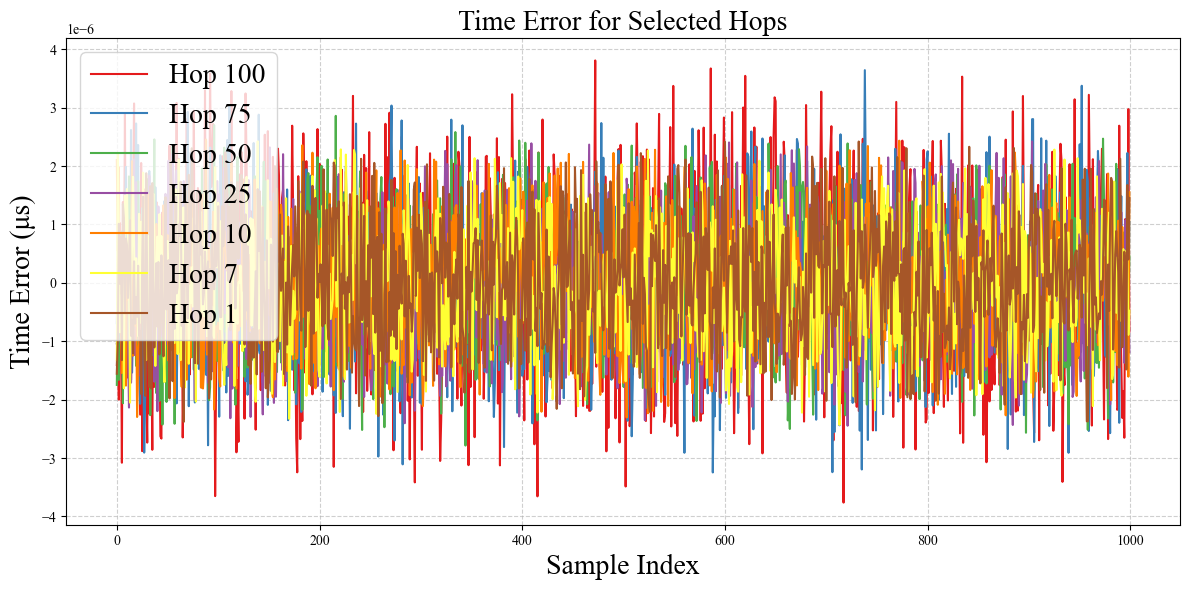

Image saved to: output_image\time_error_lines_125ms.png


<Figure size 640x480 with 0 Axes>

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 定义文件路径
input_file = 'output_data/te_data_125ms.csv'
output_dir = 'output_image'
output_file = os.path.join(output_dir, 'time_error_lines_125ms.png')

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 定义要提取的跳数和对应的颜色
# selected_hops = [1, 7, 10, 25, 50, 75, 100]
selected_hops = [100, 75, 50, 25, 10, 7, 1]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'   # 棕色
}

# 读取CSV文件
data = pd.read_csv(input_file)

# 提取指定跳数的数据
selected_data = data.iloc[:, [hop-1 for hop in selected_hops]]  # 列索引从0开始

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制每条线
for i, hop in enumerate(selected_hops):
    color_key = str(i+1) if i+1 <= len(colors) else '1'  # 如果颜色不够用，默认使用第一种颜色
    plt.plot(selected_data.iloc[:, i], 
             label=f'Hop {hop}', 
             color=colors[color_key],
             linewidth=1.5)

# 添加图例和标签
plt.xlabel('Sample Index', fontsize=20)
plt.ylabel('Time Error (μs)', fontsize=20)
plt.title('Time Error for Selected Hops', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 保存图形
plt.savefig(output_file, dpi=600, bbox_inches='tight')
print(f'Image saved to: {output_file}')


# 尝试1s 时间同步间隔

Simulating hop 1...
Simulating hop 2...
Simulating hop 3...
Simulating hop 4...
Simulating hop 5...
Simulating hop 6...
Simulating hop 7...
Simulating hop 8...
Simulating hop 9...
Simulating hop 10...
Simulating hop 11...
Simulating hop 12...
Simulating hop 13...
Simulating hop 14...
Simulating hop 15...
Simulating hop 16...
Simulating hop 17...
Simulating hop 18...
Simulating hop 19...
Simulating hop 20...
Simulating hop 21...
Simulating hop 22...
Simulating hop 23...
Simulating hop 24...
Simulating hop 25...
Simulating hop 26...
Simulating hop 27...
Simulating hop 28...
Simulating hop 29...
Simulating hop 30...
Simulating hop 31...
Simulating hop 32...
Simulating hop 33...
Simulating hop 34...
Simulating hop 35...
Simulating hop 36...
Simulating hop 37...
Simulating hop 38...
Simulating hop 39...
Simulating hop 40...
Simulating hop 41...
Simulating hop 42...
Simulating hop 43...
Simulating hop 44...
Simulating hop 45...
Simulating hop 46...
Simulating hop 47...
Simulating hop 48...
S

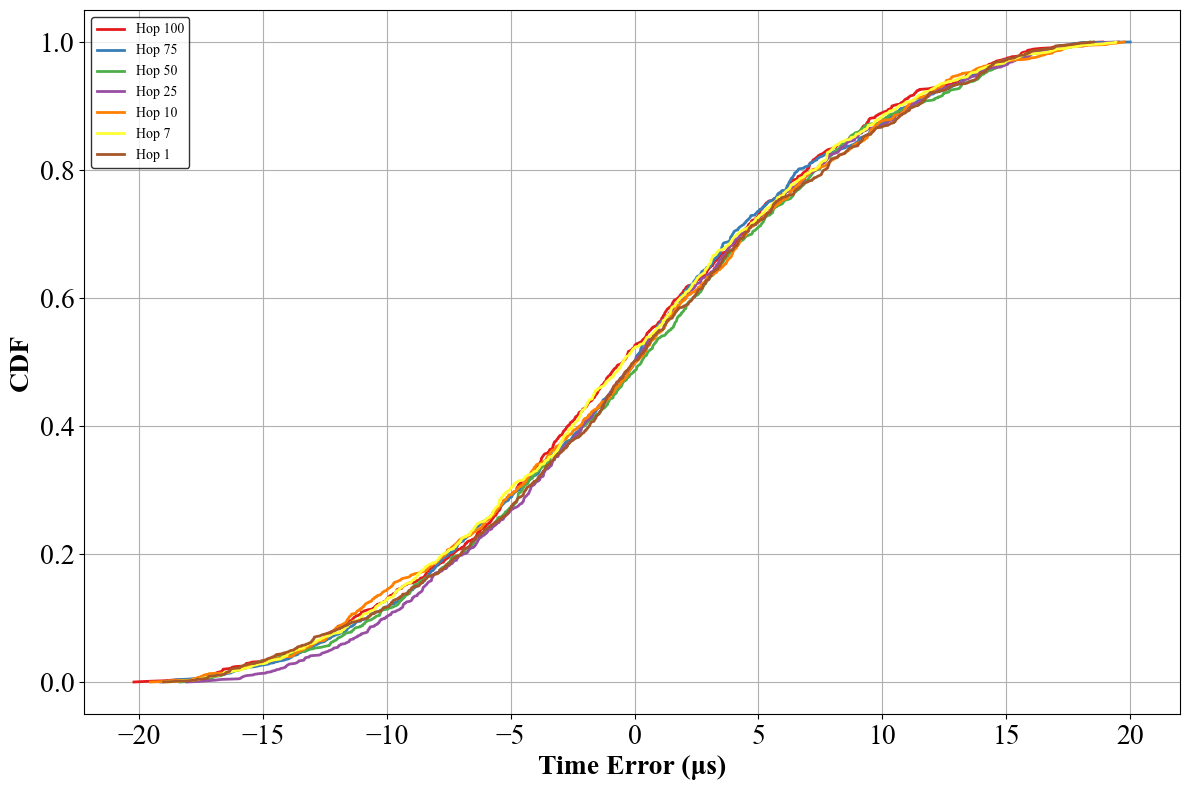

In [14]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/12 20:11
*  @Project :   pj_gptp_simulation
*  @Description :   从ieee8021as_simulation.py 拷贝来的版本
*  @FileName:   main.py
**************************************
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Create the output directory
os.makedirs("output_data", exist_ok=True)

# Parameters from the paper
PHY_JITTER_MAX = 8e-9  # 8 ns
CLOCK_GRANULARITY = 8e-9  # 8 ns
MAX_DRIFT_RATE = 10e-6  # 10 ppm
NR_ERROR = 0.1e-6  # 0.1 ppm
RESIDENCE_TIME_MAX = 1e-3  # 1 ms
PROPAGATION_DELAY = 62e-9  # 62 ns
SYNC_INTERVAL = 1.0  # 125 ms
NUM_SAMPLES = 1000  # Samples per hop


def calculate_time_error(hops, sync_interval=SYNC_INTERVAL):
    """
    Calculate time synchronization error based on the paper's equations.
    """
    # Basic error from clock drift (equation 11)
    gm_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    node_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    basic_error = (node_drift - gm_drift) * sync_interval

    # Errors due to PHY jitter and clock granularity
    if hops > 1:
        # Timestamp error
        timestamp_error = np.random.uniform(0, PHY_JITTER_MAX) + np.random.uniform(0, CLOCK_GRANULARITY)

        # Error propagation factor based on equations (16)-(23)
        error_factor = np.random.uniform(0.5, 1.0)

        # Calculate accumulated error (grows with hop count)
        accumulated_error = timestamp_error * error_factor * hops

        # From Figure 10 - error grows faster after ~30 hops
        if hops > 30:
            accumulated_error *= 1 + (hops - 30) / 100
    else:
        accumulated_error = 0

    # Total error
    total_error = basic_error + accumulated_error

    # Randomize sign (error can be positive or negative)
    if np.random.random() < 0.5:
        total_error = -total_error

    return total_error


# Generate data for all hops (1-100)
all_data = {}
for h in range(1, 101):
    print(f"Simulating hop {h}...")
    hop_errors = [calculate_time_error(h) for _ in range(NUM_SAMPLES)]
    all_data[h] = hop_errors

# Save to CSV with each column representing one hop
df = pd.DataFrame({hop: all_data[hop] for hop in range(1, 101)})
df.to_csv("output_data/te_data_1s.csv", index=False)

# Target hops for plotting
# target_hops = [1, 7, 10, 25, 50, 75, 100]
target_hops = [100, 75, 50, 25, 10, 7, 1]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'  # 棕色
}

# Create plot of time error distributions
plt.figure(figsize=(12, 8))

for i, hop in enumerate(target_hops):
    # Extract data for this hop and convert to microseconds
    errors = np.array(all_data[hop])
    errors_us = errors * 1e6

    # Sort errors for CDF plot
    sorted_errors = np.sort(errors_us)
    cumulative_prob = np.linspace(0, 1, len(sorted_errors))

    plt.plot(sorted_errors, cumulative_prob,
             label=f'Hop {hop}',
             color=colors[str(i + 1)],
             linewidth=2)

# Configure plot appearance
plt.grid(True)
plt.xlabel('Time Error (μs)', fontname='Times New Roman', fontsize=20, fontweight='bold')
plt.ylabel('CDF', fontname='Times New Roman', fontsize=20, fontweight='bold')

plt.legend(fontsize=20, frameon=True, shadow=False, edgecolor='black',prop={'family': 'Times New Roman'})

plt.xticks(fontname='Times New Roman', fontsize=20)
plt.yticks(fontname='Times New Roman', fontsize=20)

plt.tight_layout()
plt.savefig("output_image/time_error_cdf_1s.png", dpi=600)
plt.show()


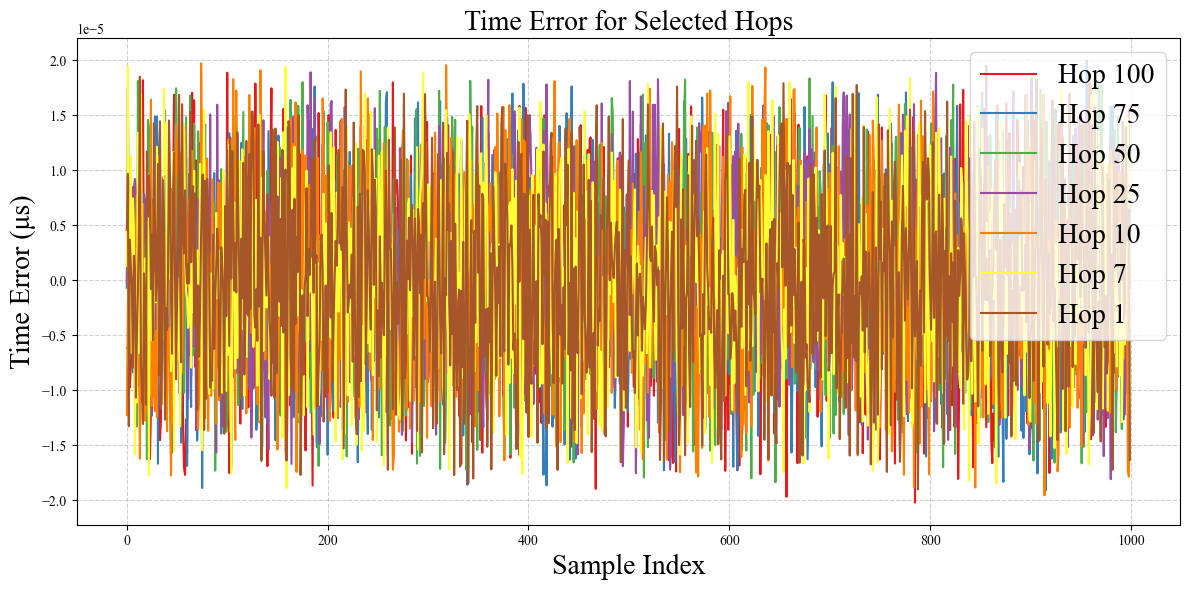

Image saved to: output_image\time_error_lines_1s.png


<Figure size 640x480 with 0 Axes>

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 设置全局字体为Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# 定义文件路径
input_file = 'output_data/te_data_1s.csv'
output_dir = 'output_image'
output_file = os.path.join(output_dir, 'time_error_lines_1s.png')

# 确保输出目录存在
os.makedirs(output_dir, exist_ok=True)

# 定义要提取的跳数和对应的颜色
# selected_hops = [1, 7, 10, 25, 50, 75, 100]
selected_hops = [100, 75, 50, 25, 10, 7, 1]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'   # 棕色
}

# 读取CSV文件
data = pd.read_csv(input_file)

# 提取指定跳数的数据
selected_data = data.iloc[:, [hop-1 for hop in selected_hops]]  # 列索引从0开始

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制每条线
for i, hop in enumerate(selected_hops):
    color_key = str(i+1) if i+1 <= len(colors) else '1'  # 如果颜色不够用，默认使用第一种颜色
    plt.plot(selected_data.iloc[:, i], 
             label=f'Hop {hop}', 
             color=colors[color_key],
             linewidth=1.5)

# 添加图例和标签
plt.xlabel('Sample Index', fontsize=20)
plt.ylabel('Time Error (μs)', fontsize=20)
plt.title('Time Error for Selected Hops', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

# 保存图形
plt.savefig(output_file, dpi=600, bbox_inches='tight')
print(f'Image saved to: {output_file}')


# 提取最大TE

In [17]:
import pandas as pd
import numpy as np

# 定义输入文件和输出文件路径
input_files = [
    "output_data/te_data.csv",
    "output_data/te_data_125ms.csv",
    "output_data/te_data_1s.csv"
]
output_file = "output_data/max_te_data.csv"

# 定义要提取的跳数
selected_hops = [10, 25, 50, 75, 100]

# 定义同步间隔标签
sync_intervals = [
    "Synchronization interval=31.25ms",
    "Synchronization interval=125ms",
    "Synchronization interval=1s"
]

# 初始化结果DataFrame
result_df = pd.DataFrame(columns=['hops'] + sync_intervals)
result_df['hops'] = selected_hops

# 读取每个文件并处理数据
for i, file_path in enumerate(input_files):
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 确保列名是字符串类型（有些可能是数字）
    df.columns = df.columns.astype(str)
    
    # 提取指定跳数的列
    selected_columns = [str(h) for h in selected_hops]
    hop_data = df[selected_columns]
    
    # 计算每列的绝对值的最大值
    max_values = hop_data.abs().max()
    
    # 将结果存入结果DataFrame
    result_df[sync_intervals[i]] = max_values.values

# 保存结果到CSV文件
result_df.to_csv(output_file, index=False)

print(f"结果已保存到 {output_file}")


结果已保存到 output_data/max_te_data.csv


In [18]:
import pandas as pd
import numpy as np

# 定义输入文件和输出文件路径
input_files = [
    "output_data/te_data.csv",
    "output_data/te_data_125ms.csv",
    "output_data/te_data_1s.csv"
]
output_file = "output_data/max_te_data_v2.csv"

# 定义要提取的跳数
selected_hops = [10, 25, 50, 75, 100]

# 定义同步间隔标签
sync_intervals = [
    "Synchronization interval=31.25ms",
    "Synchronization interval=125ms",
    "Synchronization interval=1s"
]

# 初始化结果DataFrame
result_df = pd.DataFrame(columns=['hops'] + sync_intervals)
result_df['hops'] = selected_hops

# 读取每个文件并处理数据
for i, file_path in enumerate(input_files):
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 确保列名是字符串类型（有些可能是数字）
    df.columns = df.columns.astype(str)
    
    # 提取指定跳数的列
    selected_columns = [str(h) for h in selected_hops]
    hop_data = df[selected_columns]
    
    # 计算每列的绝对值的最大值
    # max_values = hop_data.abs().max()
    max_values = hop_data.max()
    
    # 将结果存入结果DataFrame
    result_df[sync_intervals[i]] = max_values.values

# 保存结果到CSV文件
result_df.to_csv(output_file, index=False)

print(f"结果已保存到 {output_file}")


结果已保存到 output_data/max_te_data_v2.csv


# 输出的csv不太对，手动查询然后输出。

In [19]:
import pandas as pd
import numpy as np

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data.csv"

# 要读取的列索引（注意Python是0-based索引，所以实际列号减1）
columns_to_read = [9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件，只加载指定列
    # 使用usecols参数指定要读取的列索引
    df = pd.read_csv(file_path, usecols=columns_to_read)
    
    # 计算每列绝对值的最大值
    max_abs_values = {}
    for col in df.columns:
        max_abs_values[col] = np.max(np.abs(df[col]))
    
    # 打印结果
    print("各列绝对值的最大值：")
    for col, max_val in max_abs_values.items():
        print(f"列 {int(col)+1}: {max_val}")

except FileNotFoundError:
    print(f"错误：文件 {file_path} 未找到")
except Exception as e:
    print(f"发生错误: {str(e)}")


各列绝对值的最大值：
列 11: 6.601632429237326e-07
列 26: 8.119830067712917e-07
列 51: 1.254214074209956e-06
列 76: 1.9015372742263228e-06
列 101: 2.8158153711507585e-06


In [20]:
import pandas as pd
import numpy as np

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data.csv"

# 要读取的列索引（注意Python是0-based索引，所以实际列号减1）
columns_to_read = [9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件，只加载指定列
    # 使用usecols参数指定要读取的列索引
    df = pd.read_csv(file_path, usecols=columns_to_read)
    
    # 计算每列绝对值的最大值
    max_abs_values = {}
    for col in df.columns:
        max_abs_values[col] = np.max(np.abs(df[col]))
    
    # 打印结果，禁用科学计数法
    pd.set_option('display.float_format', lambda x: '%.8f' % x)  # 显示8位小数
    np.set_printoptions(suppress=True)  # 禁用科学计数法
    
    print("各列绝对值的最大值：")
    for col, max_val in max_abs_values.items():
        print(f"列 {int(col)+1}: {max_val:.8f}")  # 使用格式化字符串显示8位小数

except FileNotFoundError:
    print(f"错误：文件 {file_path} 未找到")
except Exception as e:
    print(f"发生错误: {str(e)}")


各列绝对值的最大值：
列 11: 0.00000066
列 26: 0.00000081
列 51: 0.00000125
列 76: 0.00000190
列 101: 0.00000282


In [25]:
import pandas as pd
import numpy as np

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data.csv"

# 要读取的列索引（注意Python是0-based索引，所以实际列号减1）
columns_to_read = [9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件，只加载指定列
    # 使用usecols参数指定要读取的列索引
    df = pd.read_csv(file_path, usecols=columns_to_read)
    
    # 将秒转换为微秒
    df = df * 1_000_000  # 乘以1,000,000转换为微秒
    
    # 计算每列绝对值的最大值
    max_abs_values = {}
    for col in df.columns:
        max_abs_values[col] = np.max(np.abs(df[col]))
    
    # 打印结果，禁用科学计数法
    pd.set_option('display.float_format', lambda x: '%.8f' % x)  # 显示8位小数
    np.set_printoptions(suppress=True)  # 禁用科学计数法
    
    print("各列绝对值的最大值（单位：微秒）：")
    for col, max_val in max_abs_values.items():
        print(f"列 {int(col)+1}: {max_val:.8f} μs")  # 添加μs单位说明

except FileNotFoundError:
    print(f"错误：文件 {file_path} 未找到")
except Exception as e:
    print(f"发生错误: {str(e)}")


各列绝对值的最大值（单位：微秒）：
列 11: 0.66016324 μs
列 26: 0.81198301 μs
列 51: 1.25421407 μs
列 76: 1.90153727 μs
列 101: 2.81581537 μs


# 画概率密度图

In [26]:
import pandas as pd
import numpy as np

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data_125ms.csv"

# 要读取的列索引（注意Python是0-based索引，所以实际列号减1）
columns_to_read = [9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件，只加载指定列
    # 使用usecols参数指定要读取的列索引
    df = pd.read_csv(file_path, usecols=columns_to_read)
    
    # 将秒转换为微秒
    df = df * 1_000_000  # 乘以1,000,000转换为微秒
    
    # 计算每列绝对值的最大值
    max_abs_values = {}
    for col in df.columns:
        max_abs_values[col] = np.max(np.abs(df[col]))
    
    # 打印结果，禁用科学计数法
    pd.set_option('display.float_format', lambda x: '%.8f' % x)  # 显示8位小数
    np.set_printoptions(suppress=True)  # 禁用科学计数法
    
    print("各列绝对值的最大值（单位：微秒）：")
    for col, max_val in max_abs_values.items():
        print(f"列 {int(col)+1}: {max_val:.8f} μs")  # 添加μs单位说明

except FileNotFoundError:
    print(f"错误：文件 {file_path} 未找到")
except Exception as e:
    print(f"发生错误: {str(e)}")


各列绝对值的最大值（单位：微秒）：
列 11: 2.45418522 μs
列 26: 2.44731838 μs
列 51: 2.85924205 μs
列 76: 3.64169375 μs
列 101: 3.80810096 μs


In [27]:
import pandas as pd
import numpy as np

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data_1s.csv"

# 要读取的列索引（注意Python是0-based索引，所以实际列号减1）
columns_to_read = [9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件，只加载指定列
    # 使用usecols参数指定要读取的列索引
    df = pd.read_csv(file_path, usecols=columns_to_read)
    
    # 将秒转换为微秒
    df = df * 1_000_000  # 乘以1,000,000转换为微秒
    
    # 计算每列绝对值的最大值
    max_abs_values = {}
    for col in df.columns:
        max_abs_values[col] = np.max(np.abs(df[col]))
    
    # 打印结果，禁用科学计数法
    pd.set_option('display.float_format', lambda x: '%.8f' % x)  # 显示8位小数
    np.set_printoptions(suppress=True)  # 禁用科学计数法
    
    print("各列绝对值的最大值（单位：微秒）：")
    for col, max_val in max_abs_values.items():
        print(f"列 {int(col)+1}: {max_val:.8f} μs")  # 添加μs单位说明

except FileNotFoundError:
    print(f"错误：文件 {file_path} 未找到")
except Exception as e:
    print(f"发生错误: {str(e)}")


各列绝对值的最大值（单位：微秒）：
列 11: 19.74867936 μs
列 26: 19.53221318 μs
列 51: 18.36876487 μs
列 76: 20.00384768 μs
列 101: 20.20832756 μs


---

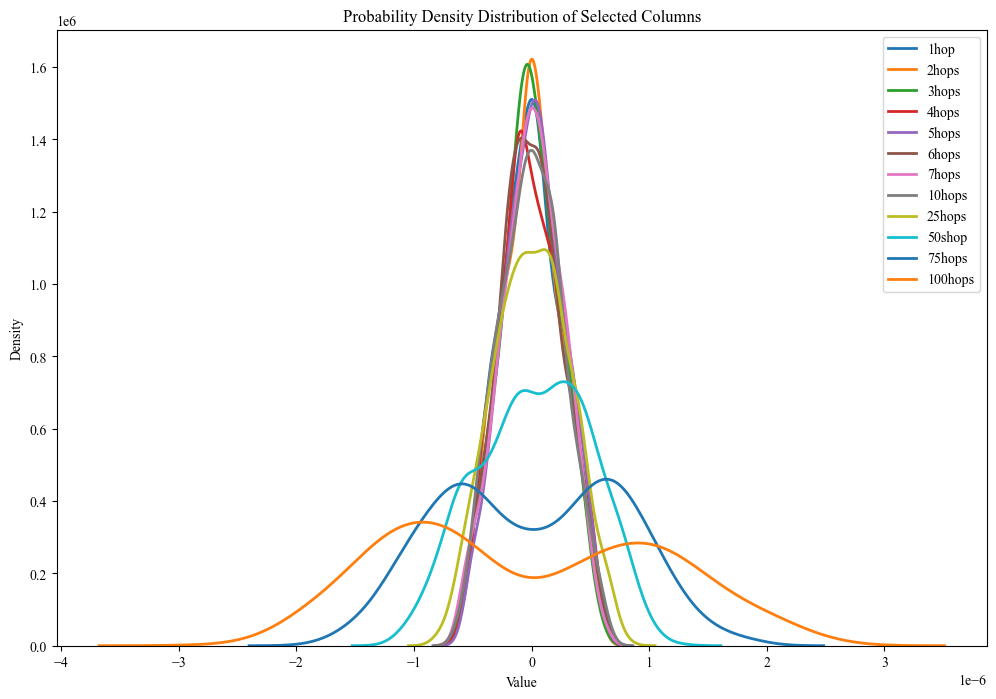

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data.csv"

# 要读取的列索引（注意Python是0-based索引，所以实际列号减1）
columns_to_read = [0,1,2,3,4,5,6,9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件，只加载指定列
    data = pd.read_csv(file_path, usecols=columns_to_read)
    
    # 设置列名（可选）
    data.columns = ['1hop','2hops','3hops','4hops','5hops','6hops', '7hops', '10hops', '25hops', '50shop', '75hops', '100hops']
    
    # 设置图形大小
    plt.figure(figsize=(12, 8))
    
    # 绘制每个列的核密度估计图
    for column in data.columns:
        sns.kdeplot(data[column], label=column, linewidth=2)
    
    # 添加图例和标题
    plt.legend()
    plt.title('Probability Density Distribution of Selected Columns')
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # 显示图形
    plt.show()

except FileNotFoundError:
    print(f"Error: 文件未找到，请检查路径: {file_path}")
except Exception as e:
    print(f"发生错误: {str(e)}")


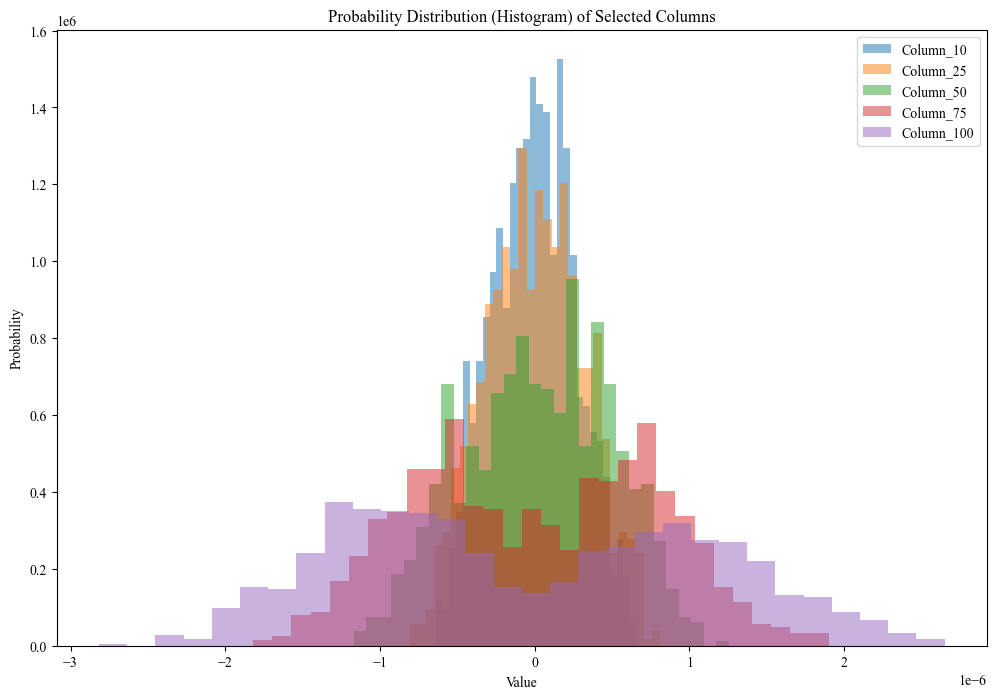

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 文件路径
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250413\output_data\te_data.csv"

# 要读取的列索引
columns_to_read = [9, 24, 49, 74, 99]  # 对应第10、25、50、75、100列

try:
    # 读取CSV文件
    data = pd.read_csv(file_path, usecols=columns_to_read)
    data.columns = ['Column_10', 'Column_25', 'Column_50', 'Column_75', 'Column_100']
    
    # 设置图形
    plt.figure(figsize=(12, 8))
    
    # 绘制直方图
    for column in data.columns:
        plt.hist(data[column], 
                bins=30, 
                alpha=0.5, 
                label=column,
                density=True)  # 显示概率而非计数
    
    plt.legend()
    plt.title('Probability Distribution (Histogram) of Selected Columns')
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.show()

except FileNotFoundError:
    print(f"Error: 文件未找到，请检查路径: {file_path}")
except Exception as e:
    print(f"发生错误: {str(e)}")
